<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/). 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")


In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [3]:
from get_data import download_data
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

data\pizza_steak_sushi directory exists...


WindowsPath('data/pizza_steak_sushi')

In [4]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
import data_setup
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x251ecb40fa0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

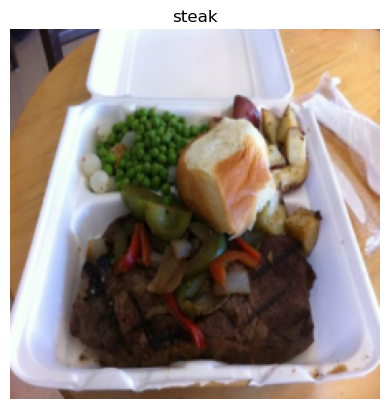

In [11]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks). 
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [48]:
class PatchEmbedding(nn.Module):
    def __init__(self, input_shape, embedding_dim, patch_size):
        super().__init__()
        self.patch_size = patch_size 

        # 1. Convolutional layer to extract non-overlapping patches and embed them
        self.patcher = nn.Conv2d(in_channels=input_shape,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)

        self.flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):

        # Validate image size
        image_height, image_width = x.shape[-2], x.shape[-1]
        assert image_height % self.patch_size == 0 and image_width % self.patch_size == 0, \
            (f"Input image dimensions must be divisible by patch_size={self.patch_size}, "
             f"but got image size ({image_height}, {image_width})")

        #print(x.shape)
        x = self.patcher(x)
        #print(x.shape)
        x = self.flatten_layer(x)
        #print(x.shape)
        return x.permute(0, 2, 1)

In [67]:
patcher = PatchEmbedding(input_shape=3, 
                        embedding_dim=768,
                        patch_size=16)

patch_embedding_output = patcher(image.unsqueeze(0))

In [52]:
class ImageEmbedder(nn.Module):
    def __init__(self, input_shape=3,
                embedding_dim=768,
                patch_size=16,
                image_size=224,
                embedding_dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim 

        self.patch_embedding = PatchEmbedding(
            input_shape=input_shape,
            embedding_dim=embedding_dim,
            patch_size=patch_size
        )

        self.num_patches = (image_size // patch_size) ** 2

        # Learnable class token 
        self.class_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))

        # Learnalbe position embedding
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, embedding_dim))

        # Adding Dropout 
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    def forward(self, x):
        batch_size = x.shape[0]
        print(x.shape)
        x = self.patch_embedding(x)
        print(x.shape)
        class_token = self.class_token.expand(batch_size, -1, -1)
        print('class_token', class_token.shape)
        x = torch.cat([class_token, x], dim=1) 
        print(x.shape)
        x = x + self.pos_embedding
        print(x.shape)
        return x 

In [62]:
embedder = ImageEmbedder(input_shape=3,
                         embedding_dim=768,
                         patch_size=16,
                         image_size=224)  

# Get final embedding
embedding_output = embedder(image.unsqueeze(0))
embedding_output

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])
class_token torch.Size([1, 1, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0875, -0.0439,  0.0507,  ..., -0.1222, -0.2763,  0.0260],
         [ 0.0743, -0.0783,  0.0043,  ...,  0.0078, -0.1967, -0.0101],
         ...,
         [-0.1373, -0.2110,  0.4619,  ..., -0.3561, -0.7521, -0.0061],
         [-0.1396, -0.3019,  0.3925,  ..., -0.2991, -0.7885, -0.0049],
         [-0.0470, -0.1907,  0.4726,  ..., -0.2799, -0.6466, -0.0565]]],
       grad_fn=<AddBackward0>)

In [66]:
tf_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation='gelu',
    batch_first=True,
    norm_first=True
)

tf_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [68]:
from torchinfo import summary

summary(model=tf_encoder_layer,
       input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [1, 196, 768]             --
├─LayerNorm: 1-1                         [1, 196, 768]             1,536
├─MultiheadAttention: 1-2                [1, 196, 768]             2,362,368
├─Dropout: 1-3                           [1, 196, 768]             --
├─LayerNorm: 1-4                         [1, 196, 768]             1,536
├─Linear: 1-5                            [1, 196, 3072]            2,362,368
├─Dropout: 1-6                           [1, 196, 3072]            --
├─Linear: 1-7                            [1, 196, 768]             2,360,064
├─Dropout: 1-8                           [1, 196, 768]             --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 4.73
Input size (MB): 0.60
Forward/backward pass size (MB): 8.43
Params size (MB): 18.90
Estimated Total Size (MB): 27.93

In [73]:
class ViT(nn.Module): 
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1, 
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size 
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(input_shape=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout 
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

In [74]:
demo_img = torch.randn(1, 3, 224, 224).to(device)
print(demo_img.shape) 

# Create ViT
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[1.0320, 0.3666, 0.1553]], device='cuda:0', grad_fn=<AddmmBackward0>)

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/). 


In [75]:
%%writefile vit.py
import torch
from torch import nn 

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class ViT(nn.Module): 
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1, 
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size 
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout 
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

Writing vit.py


## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets) 
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [76]:
from vit import ViT

imported_vit = ViT()
summary(model=imported_vit,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [79]:
# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

# Freeze all layers in pretrained ViT model 
for param in pretrained_vit.parameters():
  param.requires_grad = False

# Update the preatrained ViT head 
embedding_dim = 768 # ViT_Base

pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim, 
              out_features=len(class_names))
)

# Print a summary
summary(model=pretrained_vit, 
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [80]:
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
vit_transforms = vit_weights.transforms() # get transforms from vit_weights
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, 
                                                                                           test_dir=test_dir, # use 10% data for testing
                                                                                           transform=vit_transforms, 
                                                                                           batch_size=32)

data\pizza_steak_sushi_20_percent directory exists...


In [81]:
len(train_dataloader), len(train_dataloader_20_percent), len(test_dataloader) 

(8, 15, 3)

In [ ]:
# Train a pretrained ViT feature extractor
import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [14]:
# TODO: your code

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. 
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining** 
    * **Learning rate warmup** 
    * **Learning rate decay** 
    * **Gradient clipping** 

In [15]:
# TODO: your explanations of the above terms